Data saved to data.json


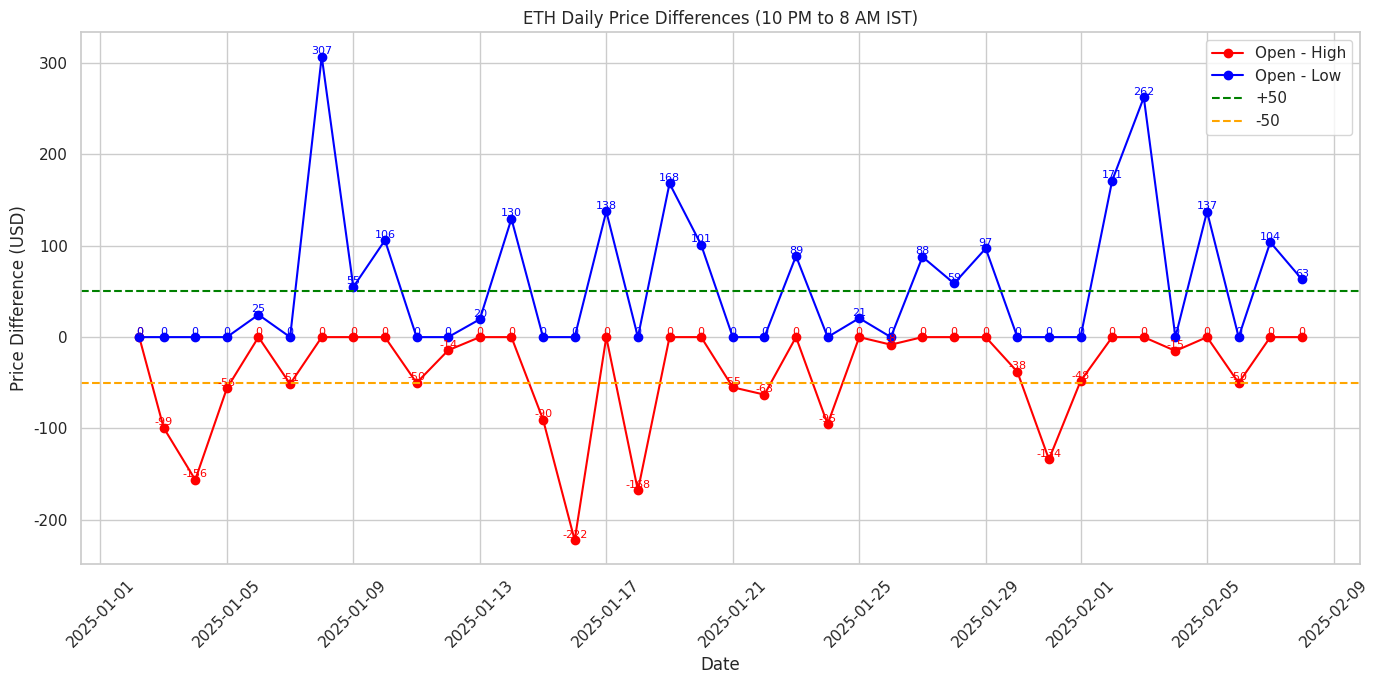

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


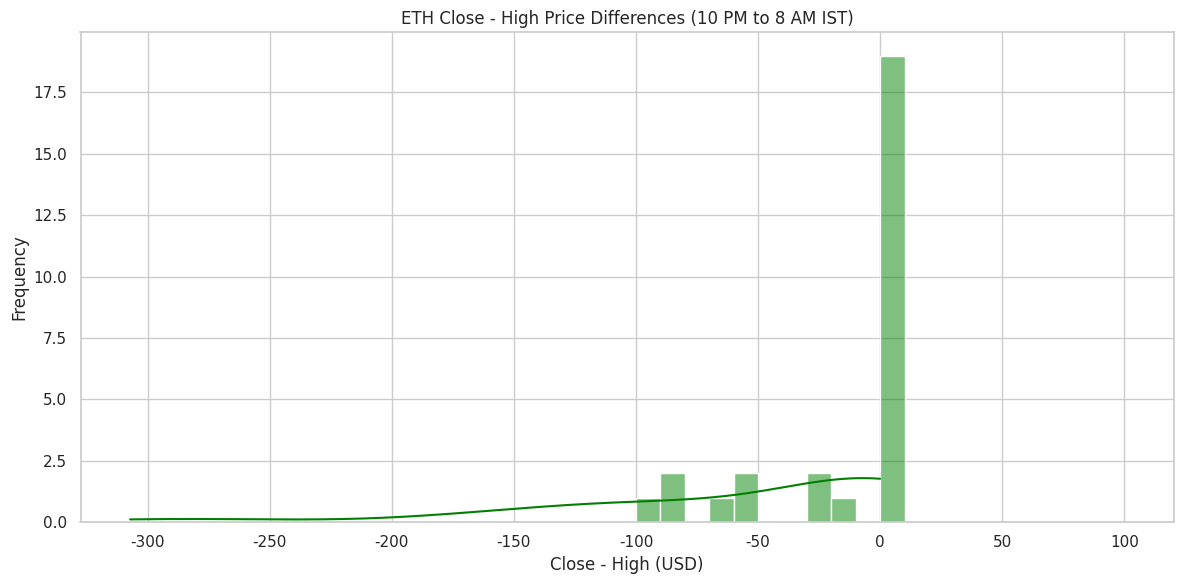

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


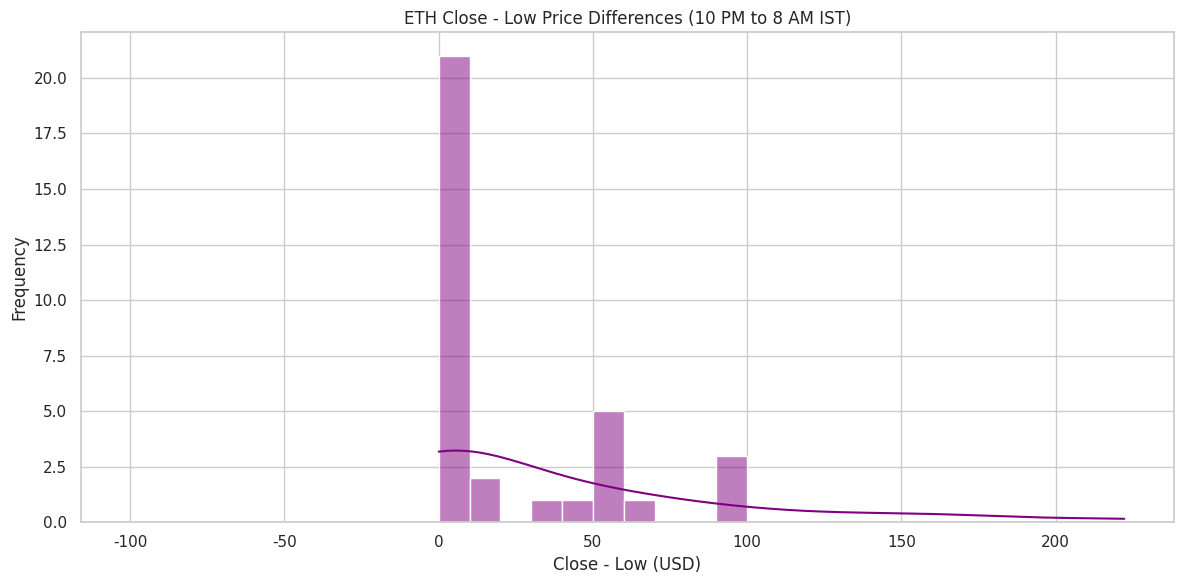

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta, time
import json
import matplotlib.pyplot as plt
import seaborn as sns

# CoinGecko API endpoint for historical data
COINGECKO_URL = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"

# Define time parameters
start_date = "2025-01-01"  # Start from 01 Jan 2025
end_date = datetime.now().strftime("%Y-%m-%d")  # Till current date
ist_offset = timedelta(hours=5, minutes=30)  # UTC to IST

# Fetch historical data from CoinGecko
params = {
    "vs_currency": "usd",
    "days": (datetime.now() - datetime.strptime(start_date, "%Y-%m-%d")).days,
    "interval": "daily"
}
response = requests.get(COINGECKO_URL, params=params)
data = response.json()

# Process data into DataFrame
prices = data['prices']
df = pd.DataFrame(prices, columns=['timestamp', 'price'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms') + ist_offset

# Resample data to 15-minute intervals (simulate 15m candles)
df.set_index('timestamp', inplace=True)
df = df.resample('15min').ffill().reset_index()

# Add placeholder columns for OHLC data (since CoinGecko only provides price)
df['open'] = df['price']
df['high'] = df['price']
df['low'] = df['price']
df['close'] = df['price']

# Filter IST time window: from 10 PM to 8 AM
df = df[(df['timestamp'].dt.time >= time(22, 0, 0)) | (df['timestamp'].dt.time <= time(8, 0, 0))]

# Create a column for the IST date (using the candle's date)
df['date'] = df['timestamp'].dt.date

# Group by date and calculate Open, High, Low, Close
grouped = df.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'timestamp': 'first'
}).reset_index()

# Calculate differences
grouped['open_high_diff'] = grouped['open'] - grouped['high']  # Open - High
grouped['open_low_diff'] = grouped['open'] - grouped['low']    # Open - Low
grouped['close_high_diff'] = grouped['close'] - grouped['high']  # Close - High
grouped['close_low_diff'] = grouped['close'] - grouped['low']    # Close - Low

# Save results to JSON
grouped.to_json('data.json', orient='records', date_format='iso')

print("Data saved to data.json")

# Visualization and Analysis
# Set style for plots
sns.set(style="whitegrid")

# Plot 1: Line plot of daily differences (Open - High and Open - Low) with horizontal lines and labels
plt.figure(figsize=(14, 7))
plt.plot(grouped['timestamp'], grouped['open_high_diff'], label='Open - High', marker='o', linestyle='-', color='red')
plt.plot(grouped['timestamp'], grouped['open_low_diff'], label='Open - Low', marker='o', linestyle='-', color='blue')

# Add horizontal lines at +50 and -50
plt.axhline(50, color='green', linestyle='--', label='+50')
plt.axhline(-50, color='orange', linestyle='--', label='-50')

# Add labels for each data point
for i, row in grouped.iterrows():
    # Offset the y-position of the labels by 2 cm (approx. 0.56 in data coordinates for this example)
    offset = 0.56  # Adjust this value as needed
    plt.text(row['timestamp'], row['open_high_diff'] + offset, f'{row["open_high_diff"]:.0f}', ha='center', va='bottom', fontsize=8, color='red')
    plt.text(row['timestamp'], row['open_low_diff'] + offset, f'{row["open_low_diff"]:.0f}', ha='center', va='bottom', fontsize=8, color='blue')

plt.title('ETH Daily Price Differences (10 PM to 8 AM IST)')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))  # Set 0 decimal places for y-axis labels
plt.tight_layout()
plt.show()

# Plot 2: Slab chart for Close - High differences
plt.figure(figsize=(12, 6))
sns.histplot(grouped['close_high_diff'].dropna(), bins=range(-100, 101, 10), kde=True, color='green')
plt.title('ETH Close - High Price Differences (10 PM to 8 AM IST)')
plt.xlabel('Close - High (USD)')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))  # Set 0 decimal places for x-axis labels
plt.tight_layout()
plt.show()

# Plot 3: Slab chart for Close - Low differences
plt.figure(figsize=(12, 6))
sns.histplot(grouped['close_low_diff'].dropna(), bins=range(-100, 101, 10), kde=True, color='purple')
plt.title('ETH Close - Low Price Differences (10 PM to 8 AM IST)')
plt.xlabel('Close - Low (USD)')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))  # Set 0 decimal places for x-axis labels
plt.tight_layout()
plt.show()